In [1]:
import json
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, learning_curve, LearningCurveDisplay

In [2]:
def load_dataset(filepath):
    with open(filepath, "r") as f:
        dataset = [ json.loads(line, parse_int = str) for line in f ]
    return dataset

def get_vectorizer( texts: list[str], *, method="countvectorize", **kwargs ) -> CountVectorizer:
    """From a list of texts, output an appropriate vectorizer either using CountVectorizer or TF-IDF depending on method argument. 

     Args:
         texts (list[str]): list of strings, each item corresponding to a text.
         method (str, optional): Method to select features. Defaults to "count-vectorizer".
         **kwargs: kwarg arguments to pass to Vectorizer classes of sklearn.
    Raises:
        ValueError: If passing an non-specified method of text feature extraction

     Returns:
         pd.DataFrame: dataframe of shape (n_samples, n_features)
    """
    #We want single digits to be tokenized. This regex considers everything as a token except whitespace.
    kwargs['token_pattern'] = r'\S+' 
    if method == "countvectorize":
        vectorizer = CountVectorizer(**kwargs)
    elif method == "tfidf":
        vectorizer = TfidfVectorizer(**kwargs)
    else:
        raise ValueError(f"{method} is not a supported method.")
    #Use texts to initialize vocabulary of vectorizer
    vectorizer.fit(texts)
    return vectorizer

def sentencify(text: list) -> str:
    sentence = " ".join(text) 
    return sentence

def loss(clf, X, y):
    probs = clf.predict_log_proba(X)
    y0 = probs[:,1]
    y1 = probs[:,0]
    loss = -y*y0 - (1-y)*y1
    loss = loss.sum()/y.size
    return loss

def balanced_acc(clf, X, y):
    y_pred = clf.predict(X)
    return balanced_accuracy_score(y, y_pred, adjusted=False)

In [3]:
dataset_2 = load_dataset("domain2_train_data.json")
datatexts_2 = [ sentencify(instance['text']) for instance in dataset_2 ]

In [4]:
tfidf_vectorizer = get_vectorizer( texts = datatexts_2,
                                    method='tfidf',
                                    use_idf=True,
                                    ngram_range=(1,3),
                                    max_df=0.995, #Ignore vocabulary appearing too frequently, probably words like "is", "are", "and", "this" etc.
                                    min_df=10, #Ignore vocabulary that is too infrequent, as this may lead to low prediction accuracy.
                                    )
print(f"no features: {tfidf_vectorizer.get_feature_names_out().size}")

no features: 91931


In [5]:
X2 = tfidf_vectorizer.transform( datatexts_2 ).toarray()
y = np.array([1]*1500 + [0]*11500)
lengths = np.zeros( (13000, 2) )
for i in range(13000):
    for k in range(2):
        lengths[i,k] = len(dataset_2[i]['text'])**(k+1)
X2 = np.hstack( (X2, lengths) )

In [6]:
scaler = MinMaxScaler()
X2_scaled = scaler.fit_transform(X2)

In [7]:
selector_clf = RandomForestClassifier(n_estimators=200, random_state=0, max_depth=10 )
selector_clf.fit(X2_scaled, y)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=0)

In [8]:
selector = SelectFromModel(selector_clf, prefit=True)
X2_selected = selector.fit_transform(X2_scaled, y)
print(f"No features: {selector.get_feature_names_out().size}")

No features: 7137


/var/folders/pn/8q7lcn491b5gv4nk1m_p0ggm0000gn/T/ipykernel_20967/440062177.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


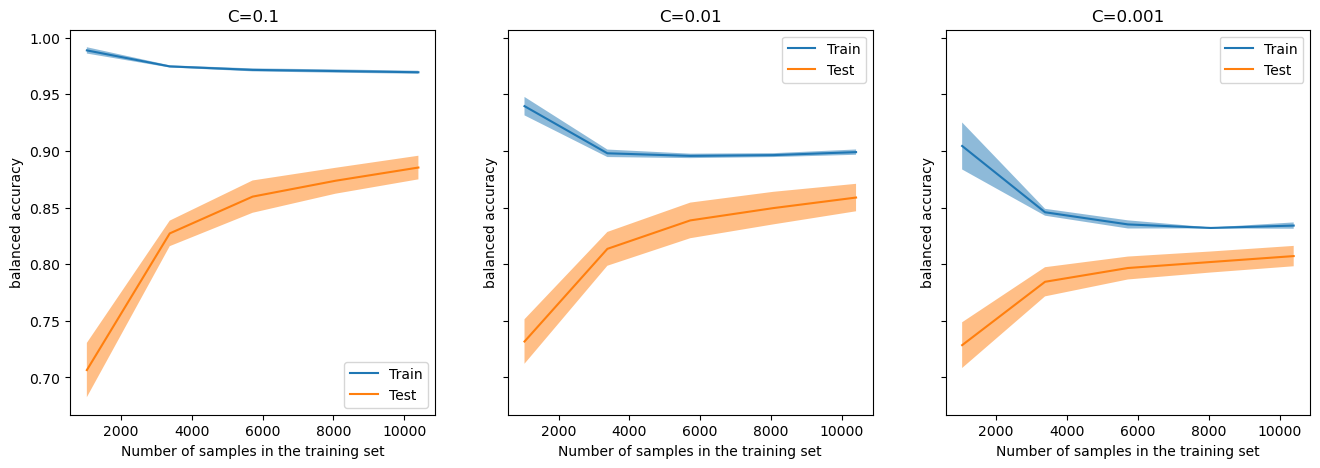

In [49]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots( nrows = 1, ncols = 3, figsize=(16,5), dpi=100, sharey=True, sharex=True )
for C, ax in zip( [0.1,0.01,0.001], axs.reshape(-1) ):
    train_sizes = np.arange(0.1,1.1,0.1)
    pipeline = LogisticRegression(C=C, tol=1e-4, random_state=1, class_weight="balanced")
    (train_sizes, 
    train_scores, 
    test_scores) = learning_curve(pipeline, X2_selected, y, 
                                  scoring=balanced_acc, 
                                  n_jobs=-1,
                                  shuffle=True,
                                  random_state=0)
    display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores)
    display.plot(ax=ax)
    ax.set_title(f"C={C}")
    ax.set_ylabel("balanced accuracy")
fig.show()

In [9]:
pipeline = Pipeline([("scaler", scaler), ("selector", selector),
                    ("clf", LogisticRegression(C=0.01, tol=1e-4, random_state=1, class_weight="balanced"))])

In [10]:
pipeline.fit(X2, y)
balanced_acc(pipeline, X2, y)

0.9009855072463768

In [11]:
import pickle as pkl
with open("domain2_lr.mdl", "wb") as f:
    pkl.dump( [tfidf_vectorizer, pipeline], f )